<a href="https://colab.research.google.com/github/MaryamNourii/EmotionDetection/blob/EN/ED_SVM_EDds_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [ ]:
train_data = pd.read_csv('data_train.csv', sep=',')
train_data = train_data.rename(columns={"Emotion": "label", "Text": "text"})

test_data = pd.read_csv('data_test.csv', sep=',')
test_data = test_data.rename(columns={"Emotion": "label", "Text": "text"})

data = pd.concat([train_data, test_data ])


In [ ]:
len(data)

11327

In [ ]:
data['label'].value_counts(normalize=True)

joy        0.205350
sadness    0.204555
anger      0.199435
neutral    0.198994
fear       0.191666
Name: label, dtype: float64

In [ ]:
train_data[train_data['text'].isnull()]

,label,text


In [ ]:
test_data[test_data['text'].isnull()]

,label,text


In [ ]:
train_x = train_data['text']
train_y = train_data['label']

test_x = test_data['text']
test_y = test_data['label']

In [ ]:
class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']

print('size of training set: %s' % (len(train_x)))
print('size of test set: %s' % (len(test_x)))


size of training set: 7934
size of test set: 3393


In [ ]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [ ]:
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

vect.fit_transform(train_x)

X_train_vect = vect.transform(train_x)
X_test_vect = vect.transform(test_x)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 69.79%

F1 Score: 69.79

COnfusion Matrix:
 [[471  64  44  51  63]
 [ 76 490  40  30  43]
 [ 59  34 483  87  44]
 [ 50  27  47 474  40]
 [ 88  57  52  29 450]]


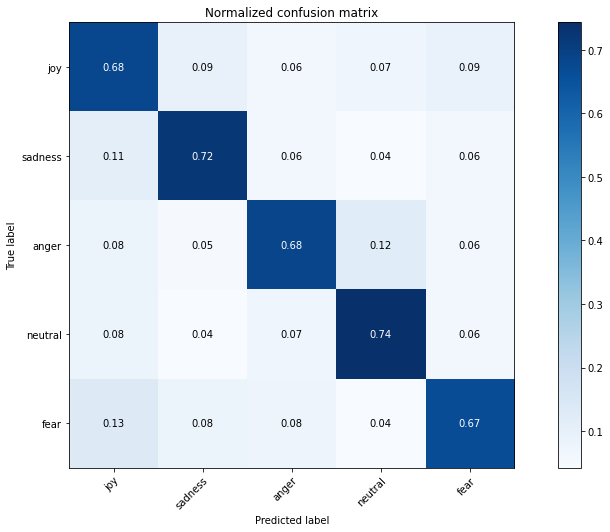

In [ ]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, train_y)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(test_y, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_y, ylog_pred))

plot_confusion_matrix(test_y, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 72.97%

F1 Score: 72.97

COnfusion Matrix:
 [[500  47  38  47  61]
 [ 60 515  41  18  45]
 [ 56  34 506  72  39]
 [ 36  23  51 483  45]
 [ 78  41  50  35 472]]


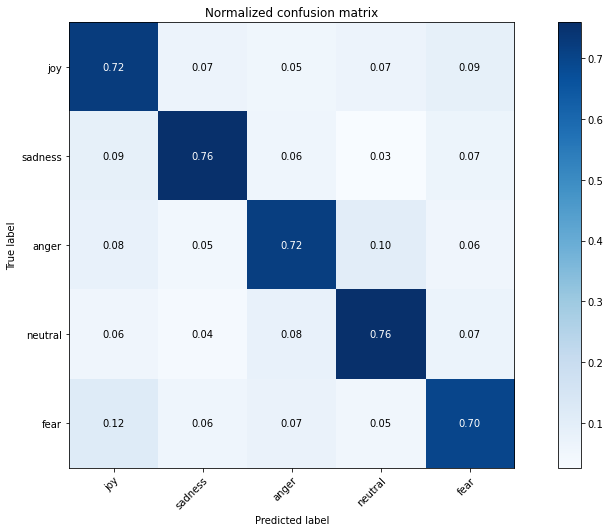

In [ ]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, train_y)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(test_y, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(test_y, ysvm_pred))

plot_confusion_matrix(test_y, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()